# April 2020 (not adjusted)

In [2]:
import numpy as np
import pandas as pd
import pyarrow as pa
import pyarrow.parquet as pq
import statsmodels.formula.api as sm
import matplotlib.pyplot as plt
import matplotlib.ticker
from matplotlib.ticker import FormatStrFormatter

pd.set_option('display.float_format', lambda x: '%.5f' % x)

In [3]:
#CONSTANTS

# to do: change the rates so that there are company specific values as well (for 2019, need Via rates), maybe store in a dataframe

NON_WAV_PER_MILE_20 = 1.10 
NON_WAV_PER_MIN_20 = 0.50 

WAV_PER_MILE_20 = 1.43 
WAV_PER_MIN_20 = 0.50 

OUT_CITY_NON_WAV_PER_MILE_20 = 1.28 
OUT_CITY_WAV_PER_MILE_20 = 1.66 
OUT_CITY_PER_MIN_20 = 0.58 


JUNO = "HV0002"
UBER = "HV0003"
VIA = "HV0004"
LYFT = "HV0005"

In [4]:
# Import Cleaned Data

apr2020 = pq.read_table("april_2020_cleaned.parquet", memory_map=True).to_pandas()


In [5]:

# Create minimum rates 2019 based on WAV and Out of City Conditions

conditions2020 = [
    (apr2020['wav_match_flag'] == 'N') & (apr2020['out_of_city'] == False),
    (apr2020['wav_match_flag'] == 'Y') & (apr2020['out_of_city'] == False),
    (apr2020['wav_match_flag'] == 'N') & (apr2020['out_of_city'] == True),
    (apr2020['wav_match_flag'] == 'Y') & (apr2020['out_of_city'] == True)]

choices2020 = [apr2020.trip_miles*NON_WAV_PER_MILE_20 + (apr2020.trip_time/60)*NON_WAV_PER_MIN_20,
              apr2020.trip_miles*WAV_PER_MILE_20 + (apr2020.trip_time/60)*WAV_PER_MIN_20,
              apr2020.trip_miles*OUT_CITY_NON_WAV_PER_MILE_20 + (apr2020.trip_time/60)*OUT_CITY_PER_MIN_20,
              apr2020.trip_miles*OUT_CITY_WAV_PER_MILE_20 + (apr2020.trip_time/60)*OUT_CITY_PER_MIN_20]

apr2020['min_rate'] = np.select(conditions2020, choices2020, default=apr2020.trip_miles*NON_WAV_PER_MILE_20 + (apr2020.trip_time/60)*NON_WAV_PER_MIN_20)

# Determine percent of trips that leave city 
# Drop Shared rides, out of town rides, and VIA rides

apr2020 = apr2020.loc[apr2020['shared_match_flag'] == "N"]
apr2020 = apr2020.loc[apr2020['hvfhs_license_num'] != VIA]
apr2020 = apr2020.loc[apr2020['out_of_city'] == False]


## Driver pay analysis

In [6]:
apr2020['driver_pay'].sum()

50232511.360000014

In [7]:
#### Distribution of driver pay



apr2020['driver_pay'].describe()

count   4067419.00000
mean         12.34997
std           8.35437
min           0.02000
25%           6.30000
50%           9.80000
75%          15.28000
max         525.00000
Name: driver_pay, dtype: float64

## Passenger Fare Analysis

In [8]:
# Total passenger fare across all rides

apr2020['base_passenger_fare'].sum()  

63935580.330000006

In [9]:
#### Distribution of passenger fare

apr2020.base_passenger_fare.describe()

count   4067419.00000
mean         15.71896
std          10.59830
min           0.02000
25%           8.02000
50%          12.32000
75%          19.44000
max         700.00000
Name: base_passenger_fare, dtype: float64

In [10]:
## Drivers' earnings compared to passenger fare

apr2020['perc_earnings_fare'] = apr2020["driver_pay"]/apr2020["base_passenger_fare"]

apr2020["perc_earnings_fare"].describe()

count   4067419.00000
mean          0.80003
std           0.68370
min           0.00195
25%           0.72363
50%           0.75856
75%           0.82961
max         615.50000
Name: perc_earnings_fare, dtype: float64

In [13]:
len(apr2020[apr2020["perc_earnings_fare"] > 1])/len(apr2020)


0.0709936694498403

In [ ]:
apr2020[apr2020["perc_earnings_fare_adj"] < 1]["perc_earnings_fare_adj"].describe()


In [15]:

## Losses on rides

apr2020['perc_uber_takes'] = 1 - apr2020["driver_pay"]/apr2020["base_passenger_fare"]

In [ ]:
#### Distribution of the percentage losses taken (among rides where a loss was taken)

apr2020[apr2020['perc_uber_takes'] < 0]['perc_uber_takes'].describe()

In [ ]:
#### Distribution of the percentage made over the minimum rate (among rides where a loss was taken)

apr2020[(apr2020['perc_uber_takes'] < 0) & (apr2020['perc_over_min_rate'] < 0)]['perc_over_min_rate'].describe()


In [ ]:

#### Distribution of percentage underpaid (among underpaid rides where a loss was taken)

apr2020[(apr2020['perc_uber_takes'] < 0) & (apr2020['perc_over_min_rate'] < 0)]['perc_over_min_rate'].describe()


In [ ]:
#### Distribution of dollar amount underpaid (among underpaid rides where a loss was taken)

apr2020[(apr2020['perc_uber_takes'] < 0) & (apr2020['perc_over_min_rate'] < 0)]['over_min_rate'].describe()


In [ ]:
#### Distribution of the dollar amount made over the minimum rate (among rides where a loss was taken)

apr2020[apr2020['perc_uber_takes'] < 0]['over_min_rate'].describe()


In [ ]:

#### Distribution of the percentage made over the minimum rate (among rides where a loss was not taken)

apr2020[apr2020['perc_uber_takes'] >= 0]['perc_over_min_rate'].describe()


In [ ]:
#### Distribution of the dollar amount made over the minimum rate (among rides where a loss was not taken)

apr2020[apr2020['perc_uber_takes'] >= 0]['over_min_rate'].describe()


In [ ]:
#### Percentage of rides that made under the minimum rate when a loss was taken

len(apr2020[(apr2020['perc_uber_takes'] < 0) & (apr2020['perc_over_min_rate'] < 0)]['perc_over_min_rate'])/ len(apr2020[apr2020['perc_uber_takes'] < 0]['perc_over_min_rate'])


In [ ]:
## Trip lengths

apr2020["trip_time_min"].describe()

In [ ]:
apr2020["trip_miles"].describe()


Text(0.5, 1.0, 'April 2020, Proportion of Passenger Fare that the Company Takes')

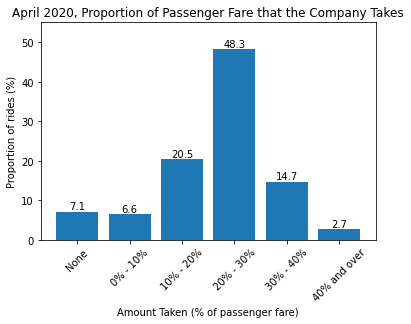

In [20]:

### Plot of proportion of passenger fare that the company takes

apr2020['perc_uber_takes'] = 1 - apr2020["driver_pay"]/apr2020["base_passenger_fare"]

bin_labels = ['None', '0% - 10%','10% - 20%', '20% - 30%', '30% - 40%', '40% and over']
bins = [float('-inf'), 0, 0.10, 0.20, 0.30, 0.40, float('inf')]

apr2020['perc_uber_takes_range'] = pd.cut(apr2020['perc_uber_takes'], bins= bins, labels=bin_labels)

fig, ax = plt.subplots(figsize=(6, 4))
ax.bar(x = bin_labels, height = apr2020.groupby("perc_uber_takes_range")["perc_uber_takes_range"].count()*100/len(apr2020["perc_uber_takes_range"]))
ax.set_ylim(0, 55)
ax.set_xlabel('Amount Taken (% of passenger fare)')
ax.xaxis.set_tick_params(rotation=45)
ax.set_ylabel('Proportion of rides (%)')
ax.bar_label(ax.containers[0], fmt = '%.1f', label_type='edge')
ax.margins(y=0.1)
ax.set_title('April 2020, Proportion of Passenger Fare that the Company Takes')